In [1]:
include("../src/NN.jl")
include("../util/datasets.jl")

using NN
using PyPlot


In [2]:
X,Y = mnistData(ttl=55000) # 0-1
println("X statistics: $(mean(X)) $(minimum(X)) $(maximum(X))")

Y = round(Int, Y)
train_set, test_set, validation_set = datasplit(X,Y;ratio=10./11.)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]
println("TrainSet: $(size(trX)) $(size(trY))")
println("ValSet  : $(size(valX)) $(size(valY))")
println("TestSet : $(size(teX)) $(size(teY))")

trX  = permutedims(reshape(trX,  (size(trX,1),  1, 28, 28)), [3,4,2,1]);
valX = permutedims(reshape(valX, (size(valX,1), 1, 28, 28)), [3,4,2,1]);
teX  = permutedims(reshape(teX,  (size(teX,1),  1, 28, 28)), [3,4,2,1]);


X statistics: 0.13013804607780613 0.0 0.99609375


In [3]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end

function sgd(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 100, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    all_losses = []

    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        epo_cor = 0
        for bid = 0:(num_batch-1)
            time_used = @elapsed begin
                batch += 1
                local sidx::Int = convert(Int64, bid*batch_size+1)
                local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                local batch_X = X[:,:,:,sidx:eidx]
                local batch_Y = Y[sidx:eidx,:]
                loss, pred = forward(net, batch_X, batch_Y)
                backward(net, batch_Y)
                append!(all_losses, mean(loss))
                for i = 1:length(net.layers)
                    layer = net.layers[i]

                    param = getParam(layer)
                    if param == nothing
                        continue
                    end

                    gradi = getGradient(layer)
                    for j = 1:length(gradi)
                        param[j] -= lrSchedule(epo) * gradi[j] / batch_size
                    end
                    setParam!(layer, param)
                end

                # _, pred = forward(net, batch_X, batch_Y; deterministics = true)
                epo_cor  += get_corr(pred, batch_Y)
                local acc = get_corr(pred, batch_Y) / batch_size
            end
#             println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)

        # Run validation set
        v_ls, v_pd = forward(net, valX, valY)
        local v_loss = mean(v_ls)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pd, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)

        # if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        # end
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function nestorove_momemtum(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)
                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue
                        end
                        gradi = getGradient(layer)
                        veloc = getVelocity(layer)

                        for j = 1:length(param)
                            gradi[j] = lrSchedule(epo) * gradi[j] / batch_size
                            veloc[j] = veloc[j] * alpha - gradi[j]
                            param[j] = param[j] + alpha * veloc[j] - gradi[j]
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function adagrad(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = (x -> (x<7)?0.01:0.001), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    cache = []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(cache, nothing)
        else
            c = []
            for j = 1:length(param)
                push!(c, zeros(size(param[j])))
            end
            push!(cache, c)
        end
    end;

    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            c = cache[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(c) == size(p) && size(c) == size(g)
                            c = c + g.^2
                            p = p - lrSchedule(epo) * g ./ (sqrt(c) + 1e-10)
                            cache[i][j] = c
                            param[j] =    p
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function RMSprop(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    verbose=0, alpha::Float64 = 0.9)

    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    cache = []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(cache, nothing)
        else
            c = []
            for j = 1:length(param)
                push!(c, zeros(size(param[j])))
            end
            push!(cache, c)
        end
    end;

    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            c = cache[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(c) == size(p) && size(c) == size(g)
                            c = c * alpha + g.^2 * (1 - alpha)
                            p = p - lrSchedule(epo) * g ./ (sqrt(c) + 1e-8)
                            cache[i][j] = c
                            param[j] =    p
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end

function Adam(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    beta_1::Float64 = 0.9, beta_2::Float64 = 0.999, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    m_t, v_t = [], []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(m_t, nothing)
            push!(v_t, nothing)
        else
            c_1, c_2 = [], []
            for j = 1:length(param)
                push!(c_1, zeros(size(param[j])))
                push!(c_2, zeros(size(param[j])))
            end
            push!(m_t, c_1)
            push!(v_t, c_2)
        end;
    end;

    iter = 1 # number of iterations
    all_losses = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            m = m_t[i][j]
                            v = v_t[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(m) == size(p) && size(m) == size(g) && size(m) == size(v)

                            # Moving average to approximate gradient with velocity
                            m = m * beta_1 + g    * (1 - beta_1)
                            v = v * beta_2 + g.^2 * (1 - beta_2)

                            # Compute the counter biased version of [m] and [v]
                            m_hat = m / (1. - beta_1^iter)
                            v_hat = v / (1. - beta_2^iter)

                            # Update gradients
                            p = p - lrSchedule(epo) * m_hat ./ (sqrt(v_hat) + 1e-4)

                            # store the things back
                            param[j] = p
                            m_t[i][j] = m
                            v_t[i][j] = v

                        end
                        setParam!(layer, param)
                    end
                    iter += 1

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end

Adam (generic function with 1 method)

In [9]:
batch_size = 500

function build_cnn()
    layers = Layer[
        InputLayer((28,28,1,batch_size)),
        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        FlattenLayer(),

        DenseLayer(256),
        ReLu(),

        DropoutLayer(0.5),
        DenseLayer(10)
    ]

    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

build_cnn (generic function with 1 method)

Epo 1 [271.946840818s] has loss :0.2920877544119726		accuracy : 0.952
Epo 2 [271.908142102s] has loss :0.17709218376881833		accuracy : 0.974
Epo 3 [270.608872357s] has loss :0.13363013656299952		accuracy : 0.98
Epo 4 [248.993007318s] has loss :0.1126584426731082		accuracy : 0.978
Epo 5 [230.358424352s] has loss :0.10725166070724965		accuracy : 0.978
Epo 6 [218.861421172s] has loss :0.09915279000952108		accuracy : 0.98
Epo 7 [218.201110971s] has loss :0.08622859177229138		accuracy : 0.982
Epo 8 [220.382746419s] has loss :0.07883596351265093		accuracy : 0.98
Epo 9 [216.326365433s] has loss :0.07832212703379518		accuracy : 0.98


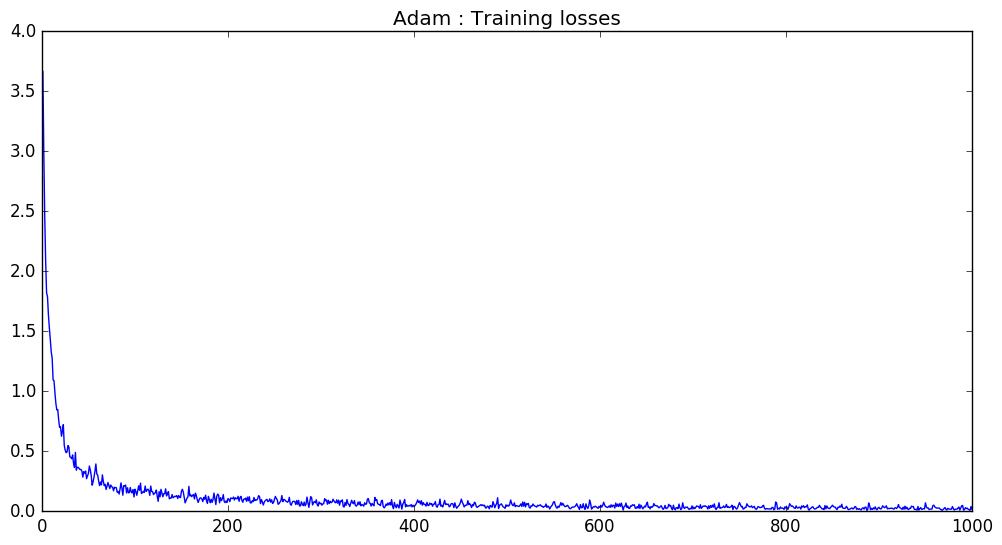

Epo 10 [217.212454778s] has loss :0.07372254608550177		accuracy : 0.984


In [10]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, adam_losses = Adam(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(adam_losses), adam_losses)
title("Adam : Training losses")
show()



Epo 1 [166.420644125s] has loss :0.28232523447633046		accuracy : 0.942
Epo 2 [163.711850581s] has loss :0.17816708564303738		accuracy : 0.954
Epo 3 [164.173174187s] has loss :0.11588263330609581		accuracy : 0.972
Epo 4 [170.898260703s] has loss :0.10080351308630264		accuracy : 0.984
Epo 5 [174.762385719s] has loss :0.08176561724555437		accuracy : 0.984
Epo 6 [167.520897811s] has loss :0.09565085310922078		accuracy : 0.976
Epo 7 [166.681959268s] has loss :0.07366085275928964		accuracy : 0.984
Epo 8 [169.890297724s] has loss :0.062127479091077686		accuracy : 0.984
Epo 9 [170.431890677s] has loss :0.05857061125993473		accuracy : 0.988


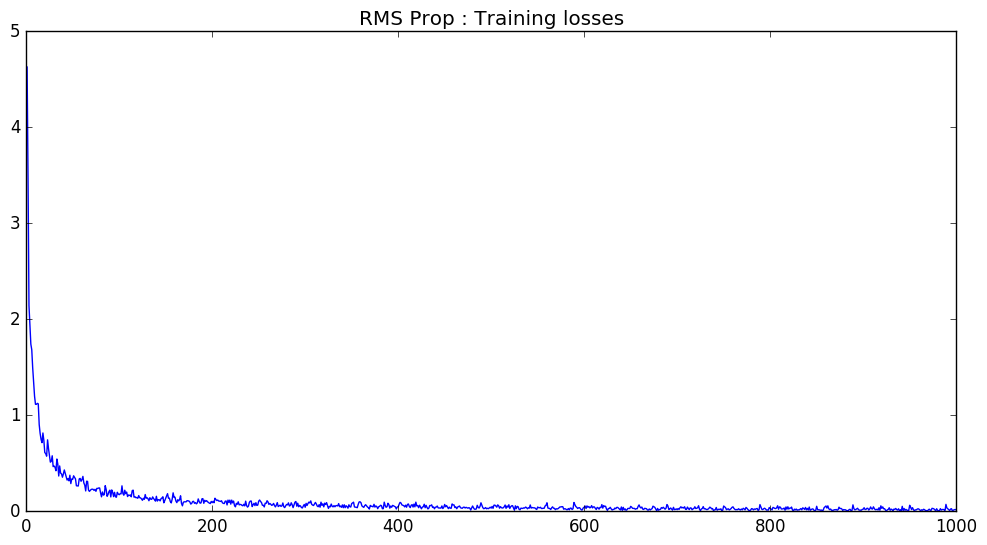

In [11]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, rmsprop_losses = RMSprop(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(rmsprop_losses), rmsprop_losses)
title("RMS Prop : Training losses")
show()


Epo 1 [166.62325391s] has loss :0.8170642617925998		accuracy : 0.868
Epo 2 [180.031553695s] has loss :0.6409283336247144		accuracy : 0.914
Epo 3 [166.278704374s] has loss :0.5551823272952298		accuracy : 0.91
Epo 4 [165.146161301s] has loss :0.5208600925708797		accuracy : 0.922
Epo 5 [173.128761107s] has loss :0.46367745427878737		accuracy : 0.93
Epo 6 [164.190861576s] has loss :0.435888699421342		accuracy : 0.936
Epo 7 [164.404819835s] has loss :0.40697789714917454		accuracy : 0.936
Epo 8 [166.34531066s] has loss :0.38012549023614134		accuracy : 0.942
Epo 9 [167.208595199s] has loss :0.3820329764494116		accuracy : 0.946


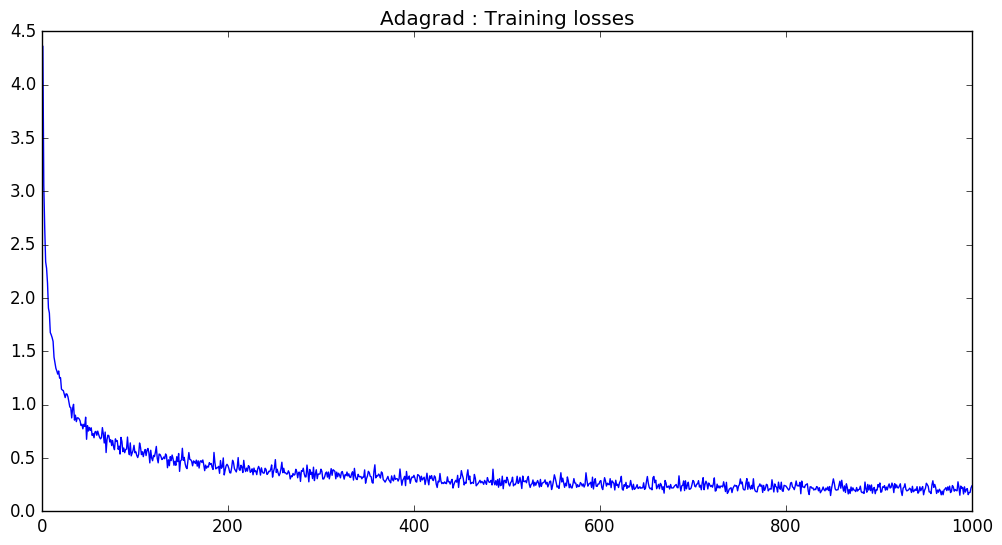

In [12]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, adagrad_losses = adagrad(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(adagrad_losses), adagrad_losses)
title("Adagrad : Training losses")
show()



Epo 1 [179.852837771s] has loss :0.3323494818868947		accuracy : 0.9
Epo 2 [181.983742287s] has loss :0.20061892552239677		accuracy : 0.942
Epo 3 [172.381731688s] has loss :0.2092751850481941		accuracy : 0.94
Epo 4 [169.55890002s] has loss :0.1545528804429382		accuracy : 0.952
Epo 5 [167.52916101s] has loss :0.14559707525416635		accuracy : 0.962
Epo 6 [167.70546607s] has loss :0.13741264691496496		accuracy : 0.946
Epo 7 [167.934244175s] has loss :0.12440788233197177		accuracy : 0.956
Epo 8 [163.647592782s] has loss :0.10237082697410674		accuracy : 0.968
Epo 9 [163.406297386s] has loss :0.11459484393455362		accuracy : 0.966


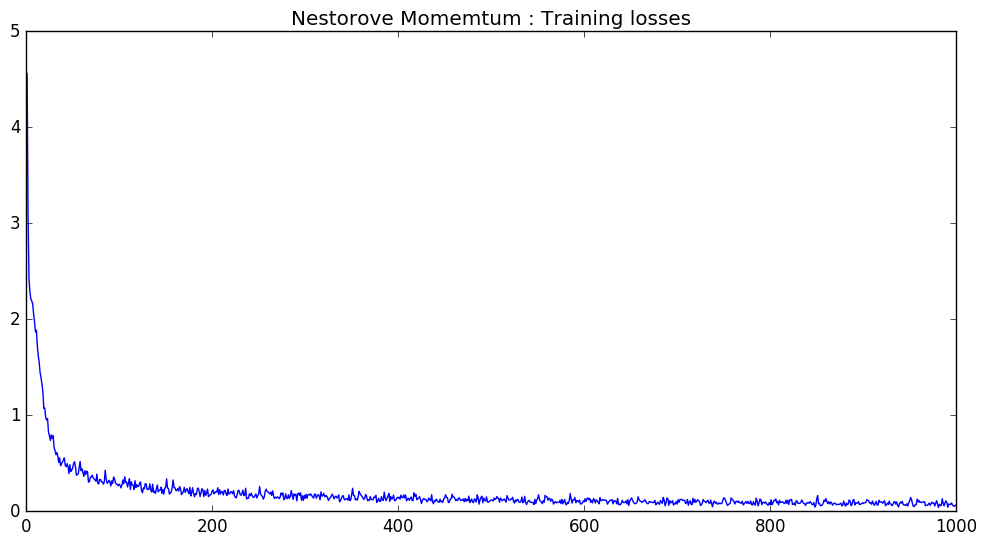

In [13]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, nest_momemtum_losses = nestorove_momemtum(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.01, verbose=1
)

figure(figsize=(12,6))
plot(1:length(nest_momemtum_losses), nest_momemtum_losses)
title("Nestorove Momemtum : Training losses")
show()


Epo 1 num batches : 100.0
Epo 1 has loss :1.5818421096991384		accuracy : 0.47466
Epo 2 num batches : 100.0
Epo 2 has loss :1.1767430282218507		accuracy : 0.75682
Epo 3 num batches : 100.0
Epo 3 has loss :0.9683752880035797		accuracy : 0.83014
Epo 4 num batches : 100.0
Epo 4 has loss :0.838698597427055		accuracy : 0.86166
Epo 5 num batches : 100.0
Epo 5 has loss :0.7487649815826147		accuracy : 0.881
Epo 6 num batches : 100.0
Epo 6 has loss :0.681730809489923		accuracy : 0.89554
Epo 7 num batches : 100.0
Epo 7 has loss :0.6291291861247749		accuracy : 0.90446
Epo 8 num batches : 100.0
Epo 8 has loss :0.5865401078896932		accuracy : 0.91454
Epo 9 num batches : 100.0
Epo 9 has loss :0.5513012188521185		accuracy : 0.91936
Epo 10 num batches : 100.0


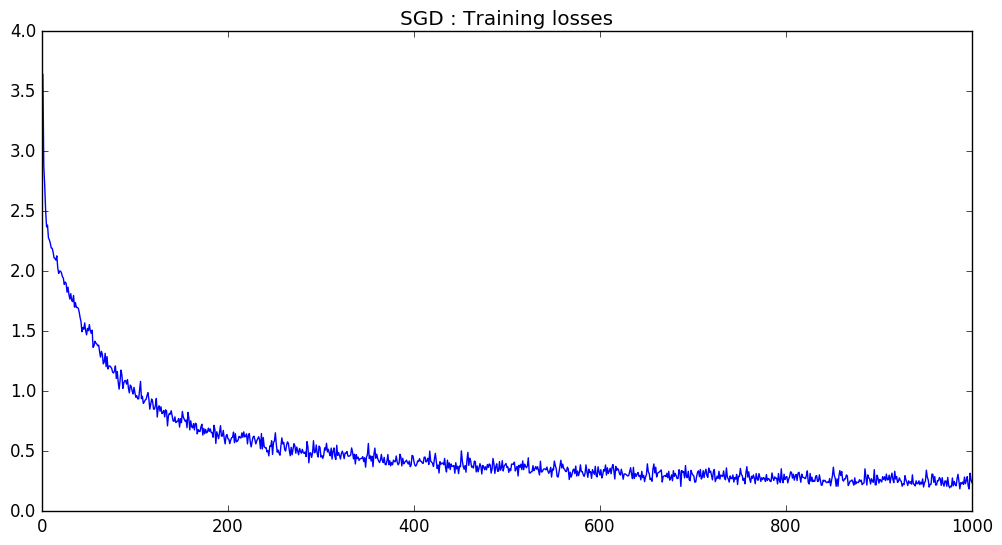

In [14]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, sgd_losses = sgd(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.01, verbose=1
)

figure(figsize=(12,6))
plot(1:length(sgd_losses), sgd_losses)
title("SGD : Training losses")
show()

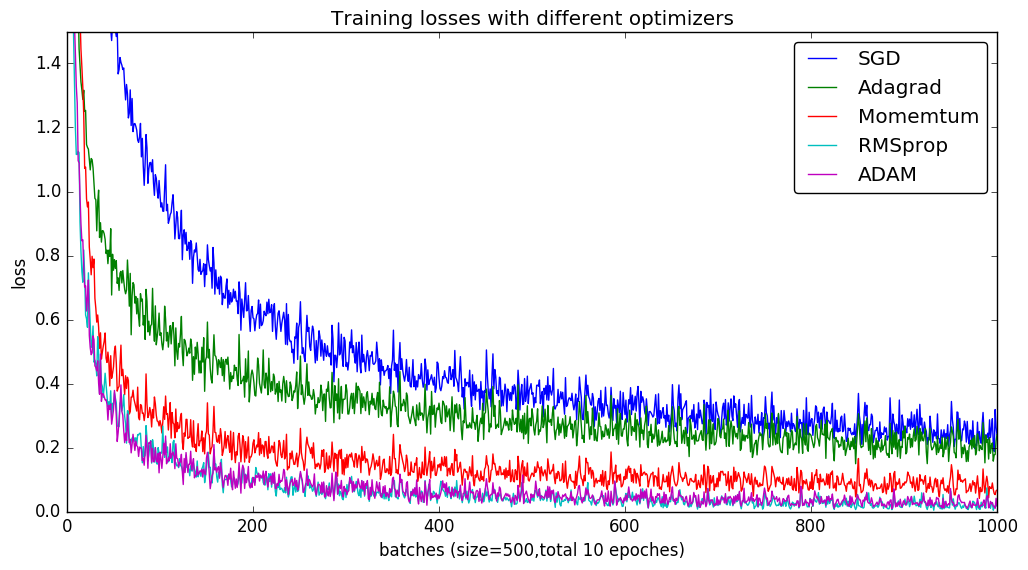

In [35]:
figure(figsize=(12,6))
plot(1:length(sgd_losses), sgd_losses,       label="SGD")
plot(1:length(adagrad_losses), adagrad_losses, label="Adagrad")
plot(1:length(nest_momemtum_losses), nest_momemtum_losses; label="Momemtum")
plot(1:length(rmsprop_losses), rmsprop_losses, label="RMSprop")
plot(1:length(adam_losses), adam_losses,       label="ADAM")
ylim([0, 1.5])
xlabel("batches (size=500,total 10 epoches)")
ylabel("loss")
title("Training losses with different optimizers")
legend(loc="upper right",fancybox="true")
savefig("optimizers.png")
show()